In [77]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
from scipy.interpolate import griddata
import xarray as xr
import pandas as pd

import matplotlib.pyplot as plt
import cartopy as cart
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cmocean

from datetime import timedelta as delta
from datetime import datetime

import networkx as nx

from parcels import (grid, Field, FieldSet, ParticleSet, JITParticle, ScipyParticle, AdvectionRK4,
                     ErrorCode, ParticleFile, Variable, plotTrajectoriesFile)

from importlib import reload
import sys
sys.path.append('/home/students/4302001/arctic-connectivity/tools')
sys.path.append('/Users/daanreijnders/surfdrive/Thesis/repo/tools')
import plot
import lifeline
import community
import fieldsetter
import advectParticles

In [78]:
reload(plot)
reload(lifeline)
reload(community)
reload(fieldsetter)
reload(advectParticles)

<module 'advectParticles' from '/home/students/4302001/arctic-connectivity/tools/advectParticles.py'>

In [31]:
# Specify paths to velocity field and mesh
#readdir_ocean = '/Users/daanreijnders/Datasets/'
#readdir_ice = '/Users/daanreijnders/Datasets/'

readdir_ice_control = '/data/oceanparcels/input_data/CESM/0.1_deg/control/ice/arctic/'
readdir_ocean_control = '/data/oceanparcels/input_data/CESM/0.1_deg/control/ocean/arctic/'
readdir_ocean_rcp = '/data/oceanparcels/input_data/CESM/0.1_deg/rcp8.5/ocean/arctic/'
readdir_mesh = '/scratch/DaanR/fields/'

fieldfile_ocean_control_old = 'daily_CESM_0.1degree_controlrun_year_300_arctic_region_timed_donotuse.nc'
fieldfile_ocean_control_new = 'daily_CESM_0.1degree_controlrun_year_300_arctic_timed_no_cord.nc'
fieldfile_ice_control = 'monthly_icefields_CESM_0.1degree_controlrun_year_300_arctic'
meshfile = 'POP_grid_coordinates.nc'

fieldfile_ocean_rcp1 = 'daily_CESM_0.1degree_rcp8.5run_years_2000-2010_arctic.nc'
fieldfile_ocean_rcp2 = 'daily_CESM_0.1degree_rcp8.5run_years_2011-2020_arctic.nc'

writedir = '/scratch/DaanR/psets/'

In [94]:
ds_field_control_old = xr.open_dataset(readdir_ocean_control+fieldfile_ocean_control_old)
ds_field_control_new = xr.open_dataset(readdir_ocean_control+fieldfile_ocean_control_new)
ds_field_rcp1 = xr.open_dataset(readdir_ocean_rcp+fieldfile_ocean_rcp1)
ds_field_rcp2 = xr.open_dataset(readdir_ocean_rcp+fieldfile_ocean_rcp2)
U_field_control_old = ds_field_control_old['UVEL_5m']
V_field_control_old = ds_field_control_old['VVEL_5m']
U_field_control_new = ds_field_control_new['UVEL_5m']
V_field_control_new = ds_field_control_new['VVEL_5m']
U_field_rcp1 = ds_field_rcp1['UVEL_5m']
V_field_rcp1 = ds_field_rcp1['VVEL_5m']
U_field_rcp2 = ds_field_rcp2['UVEL_5m']
POP_mesh = xr.open_dataset(readdir_mesh+meshfile)
ULAT = POP_mesh['ULAT']
ULON = POP_mesh['ULON']

In [33]:
U_field_control_old['time'][0] # Check timestamp associated with field at index 115

<xarray.DataArray 'time' ()>
array('2000-01-01T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2000-01-01
Attributes:
    standard_name:  time
    axis:           T

In [34]:
U_field_rcp1.record #record is index

<xarray.DataArray 'record' (record: 4007)>
array([   0,    1,    2, ..., 4004, 4005, 4006])
Dimensions without coordinates: record

In [35]:
U_field_rcp2.record

<xarray.DataArray 'record' (record: 4007)>
array([   0,    1,    2, ..., 4004, 4005, 4006])
Dimensions without coordinates: record

In [36]:
U_field_rcp1.time # First set runs from 2001-01-09 till 2010-31-31

<xarray.DataArray 'time' (time: 1)>
array([20000109.])
Coordinates:
  * time     (time) float64 2e+07
Attributes:
    standard_name:  time
    units:          day as %Y%m%d.%f
    calendar:       proleptic_gregorian
    axis:           T

In [37]:
U_field_rcp2.time 

<xarray.DataArray 'time' (time: 1)>
array([20000109.])
Coordinates:
  * time     (time) float64 2e+07
Attributes:
    standard_name:  time
    units:          day as %Y%m%d.%f
    calendar:       proleptic_gregorian
    axis:           T

In [38]:
U_field_rcp1.shape

(4007, 1, 600, 3600)

In [39]:
U_field_control_old.shape

(365, 601, 3600)

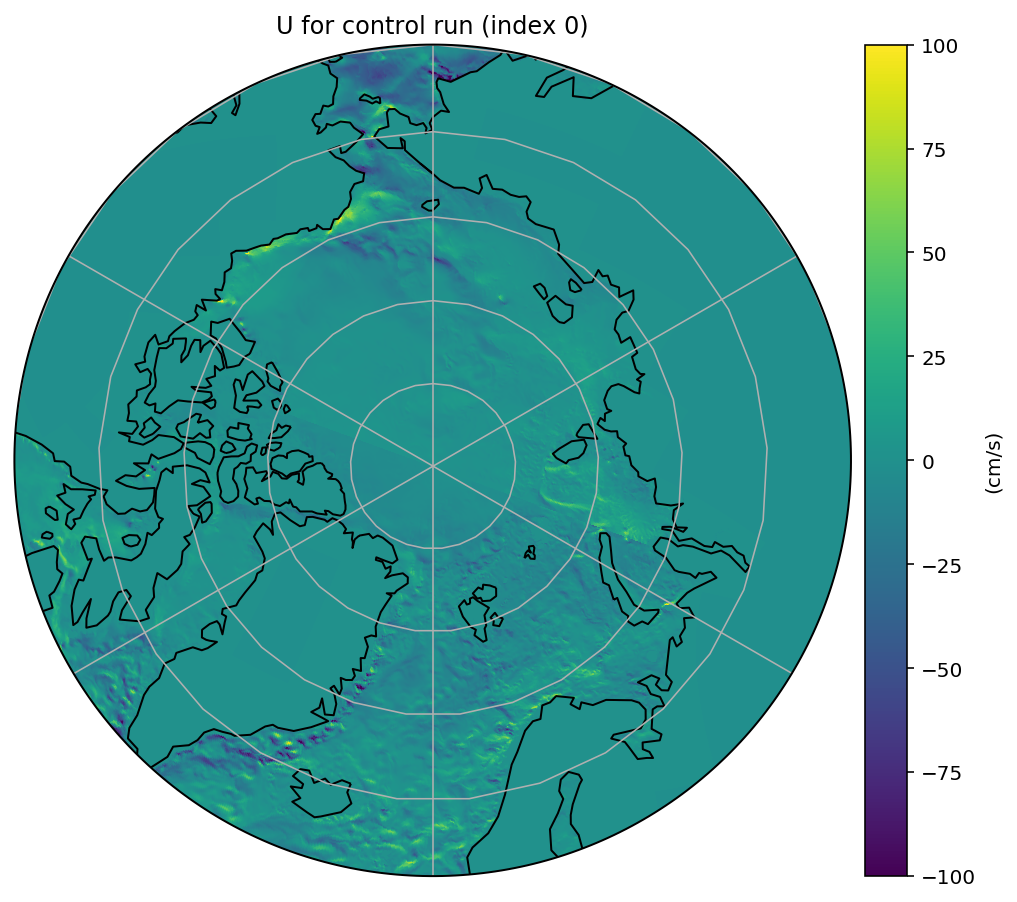

In [81]:
fig, ax = plot.field_from_dataset(ULON, ULAT, U_field_control_new[0,:,:], latRange=(60,90), polar=True, vmin=-100, vmax=100, size=(8,8), title='U for control run (index 0)', units='cm/s', export="U_control_index_0")

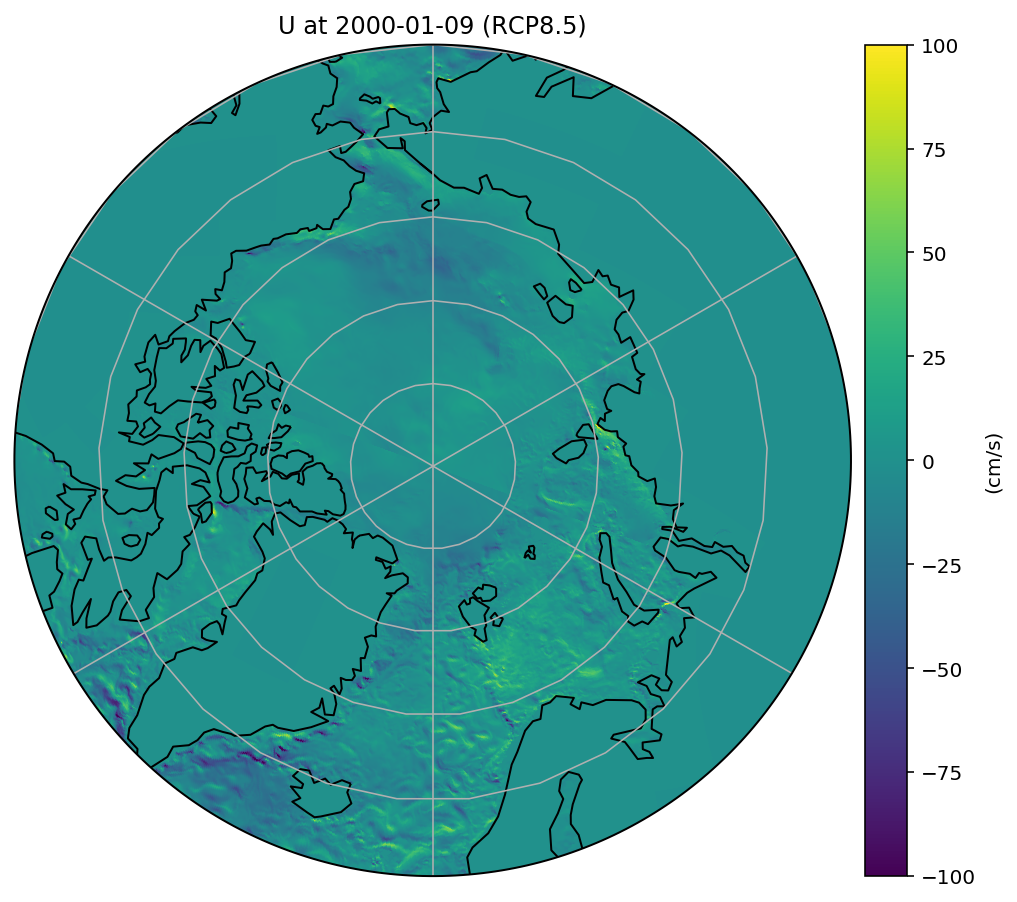

In [82]:
fig, ax = plot.field_from_dataset(ULON, ULAT, U_field_rcp1[0,0,:,:], latRange=(60,90), polar=True, vmin=-100, vmax=100, size=(8,8), title='U at 2000-01-09 (RCP8.5)', units='cm/s', export="U_RCP_2000-01-09")

(<Figure size 432x288 with 2 Axes>,
 <cartopy.mpl.geoaxes.GeoAxesSubplot at 0x7f9852de9ef0>)

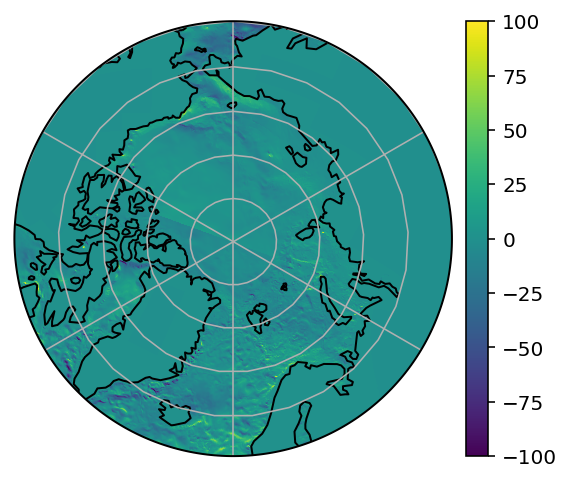

In [48]:
plot.field_from_dataset(ULON, ULAT, U_field_rcp1[-10,0,:,:], latRange=(60,90), polar=True, vmin=-100, vmax=100)

(<Figure size 432x288 with 2 Axes>,
 <cartopy.mpl.geoaxes.GeoAxesSubplot at 0x7f9848d2da20>)

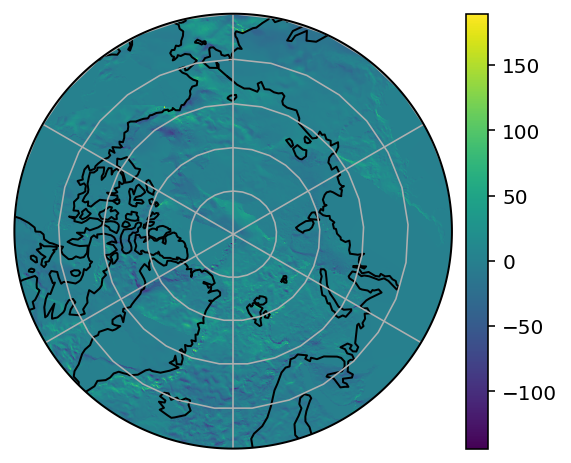

In [49]:
plot.field_from_dataset(ULON, ULAT, U_field_control_old[300,1:,:]-U_field_control_old[0,1:,:], latRange=(60,90), polar=True)

CPU times: user 5.02 s, sys: 335 ms, total: 5.35 s
Wall time: 5.13 s


(<Figure size 432x288 with 2 Axes>,
 <cartopy.mpl.geoaxes.GeoAxesSubplot at 0x7fe915db4668>)

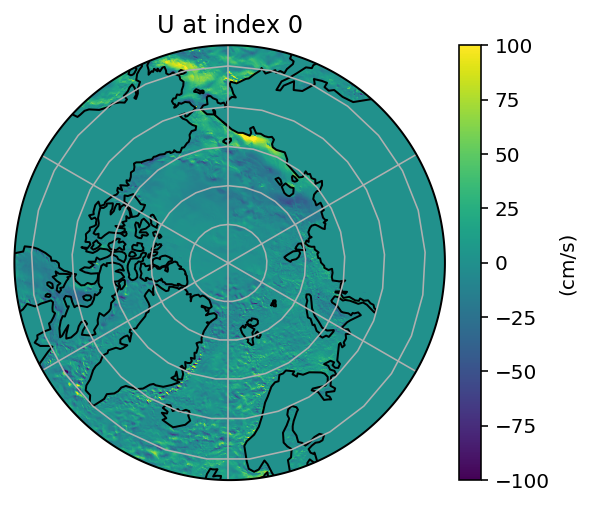

In [42]:
%%time
plot.field_from_dataset(ULON, ULAT, U_field_control_new[300,:,:]-U_field_control_new[0,:,:], latRange=(57,90), polar=True, vmin=-100, vmax=100, units='cm/s')

# Comparing RCP datasets
First we construct a mask of land cells.

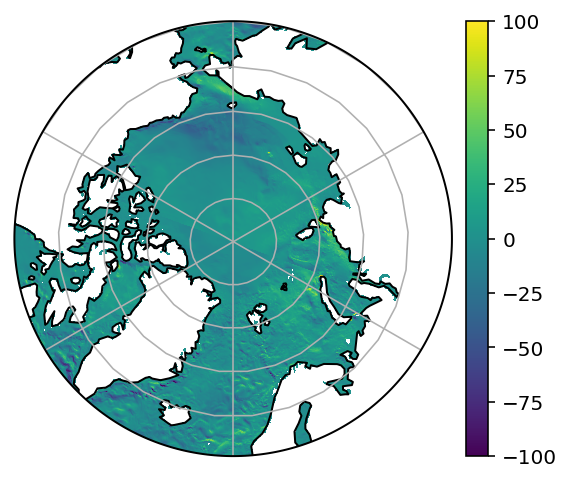

In [51]:
ma0 = ma.masked_equal(U_field_rcp1[1,0,:,:], 0)
ma1 = ma.masked_equal(U_field_rcp1[1,0,:,:], -1)
mask = np.logical_and(ma0, ma1).mask
fig, ax = plot.field_from_dataset(ULON, ULAT, ma.array(U_field_rcp1[1,0,:,:], mask=mask), latRange=(60,90), polar=True, units='cm/s', vmin=-100, vmax=100)

(<Figure size 432x288 with 2 Axes>,
 <cartopy.mpl.geoaxes.GeoAxesSubplot at 0x7f9848b3f390>)

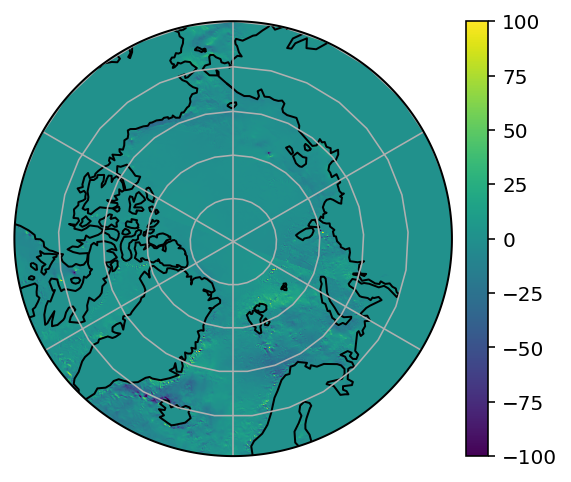

In [52]:
diff_rcp1 = U_field_rcp1[-1,0,:,:] - U_field_rcp1[-2,0,:,:]
plot.field_from_dataset(ULON, ULAT, diff_rcp1, latRange=(60,90), polar=True, vmin=-100, vmax=100)

(<Figure size 432x288 with 2 Axes>,
 <cartopy.mpl.geoaxes.GeoAxesSubplot at 0x7f9848a6e3c8>)

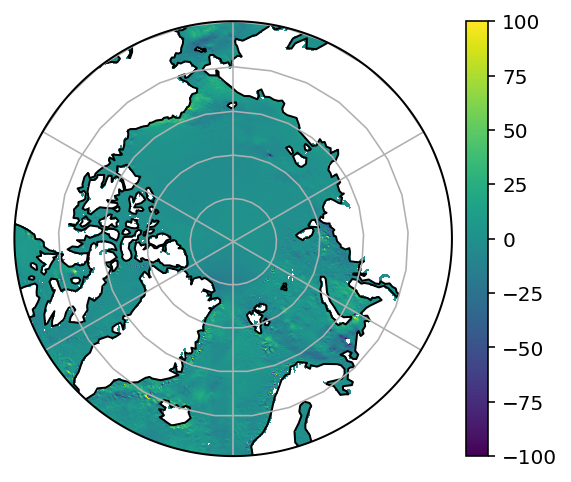

In [53]:
diff_rcp12 = ma.array(U_field_rcp2[0,0,:,:], mask=mask) - ma.array(U_field_rcp1[-1,0,:,:],mask=mask)
plot.field_from_dataset(ULON, ULAT, diff_rcp12, latRange=(60,90), polar=True, vmin=-100, vmax=100)

In [54]:
var_rcp12 = np.var(diff_rcp12)
mean_rcp12 = np.mean(diff_rcp12)
print(var_rcp12)
print(mean_rcp12)

67.6828629358863
-0.0883405718820119


To check whether the transition between data chunks is smooth, we plot the time series of variance in difference between time indices in the last 100 days of the first dataset and the first 100 days of the second dataset

In [55]:
diff_last_100 = np.diff(ma.array(U_field_rcp1[-101:-1,0,:,:], mask=np.tile(mask, (100,1))), axis=0)
var_last_100 = np.var(diff_last_100, axis=(1,2))
mean_last_100 = np.mean(diff_last_100, axis=(1,2))
diff_first_100 = np.diff(ma.array(U_field_rcp2[0:100,0,:,:], mask=np.tile(mask, (100,1))), axis=0)
var_first_100 = np.var(diff_first_100, axis=(1,2))
mean_first_100 = np.mean(diff_first_100, axis=(1,2))

In [56]:
vararr = np.hstack((var_last_100, var_rcp12, var_first_100))
meanarr = np.hstack((mean_last_100, mean_rcp12, mean_first_100))

In [57]:
fvar, Pxxvar = signal.periodogram(vararr)
fmean, Pxxmean = signal.periodogram(meanarr)

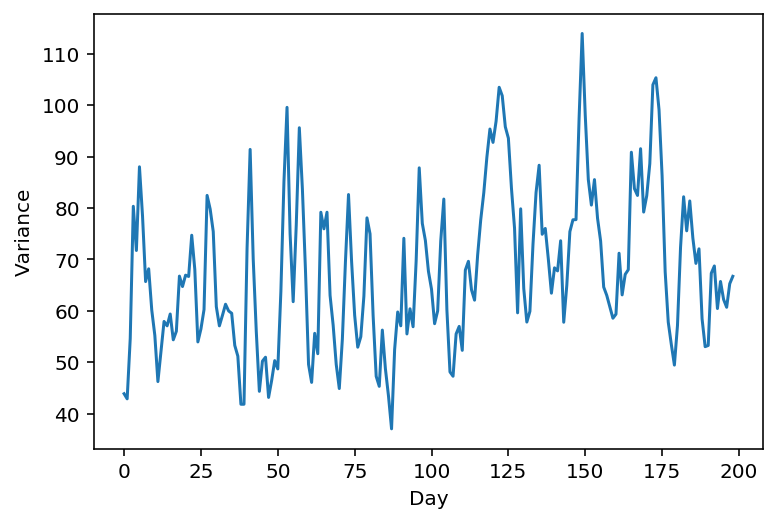

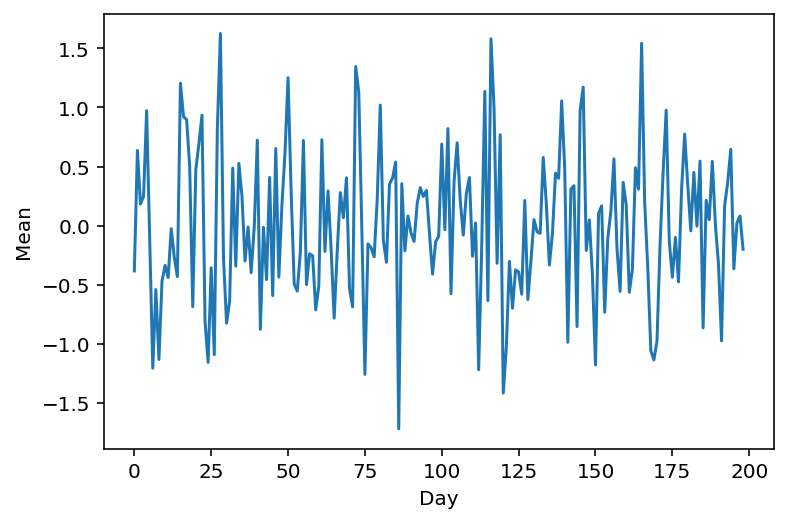

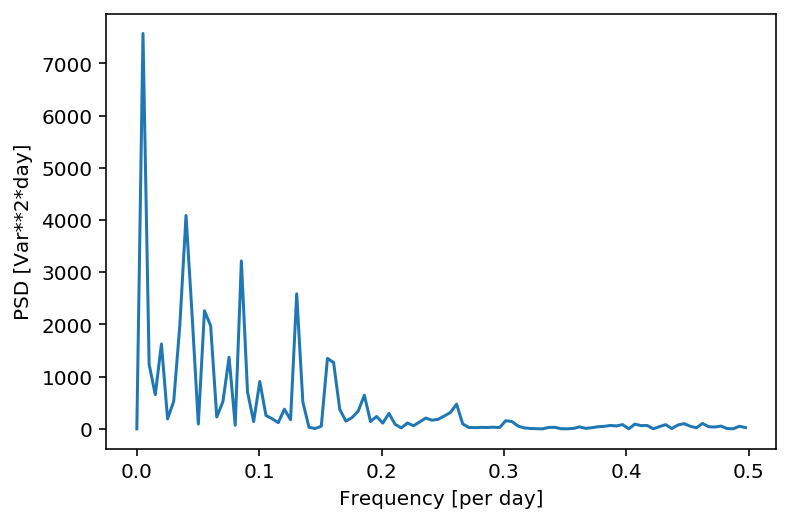

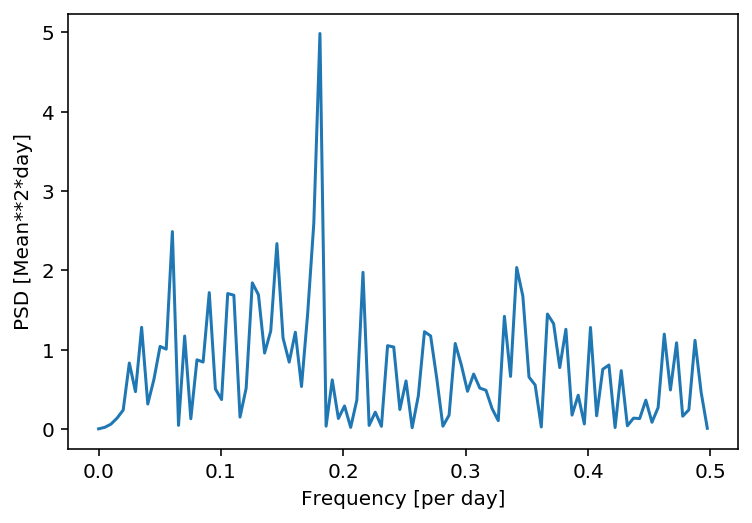

In [58]:
plt.plot(vararr)
plt.xlabel('Day')
plt.ylabel('Variance')
plt.show()

plt.plot(meanarr)
plt.xlabel('Day')
plt.ylabel('Mean')
plt.show()

plt.plot(fvar, Pxxvar)
plt.xlabel('Frequency [per day]')
plt.ylabel('PSD [Var**2*day]')
plt.show()

plt.plot(fmean, Pxxmean)
plt.xlabel('Frequency [per day]')
plt.ylabel('PSD [Mean**2*day]')
plt.show()

We see no extraordinarily high variance in the difference of the data around the change of age

# Calculate Gradient

In [46]:
RCP85_gradientUx, RCP85_gradientUy = np.gradient(U_field_rcp1[0,0,:,:])

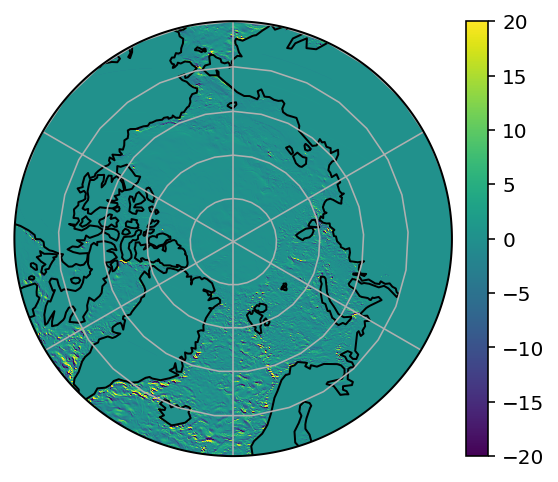

In [50]:
fig, ax = plot.field_from_dataset(ULON, ULAT, RCP85_gradientUx, latRange=(60,90), polar=True, vmin=-20, vmax=20)

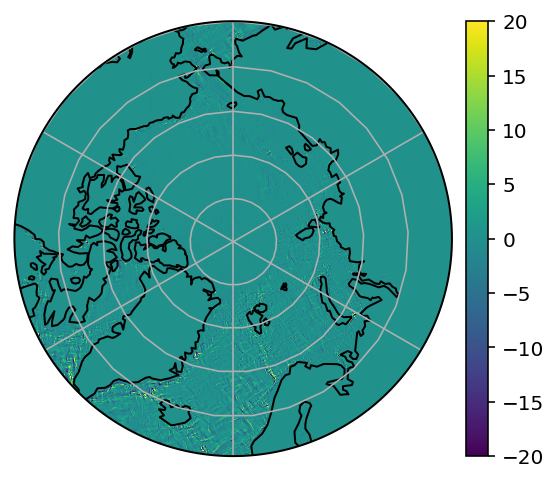

In [49]:
fig, ax = plot.field_from_dataset(ULON, ULAT, RCP85_gradientUy, latRange=(60,90), polar=True, vmin=-20, vmax=20)

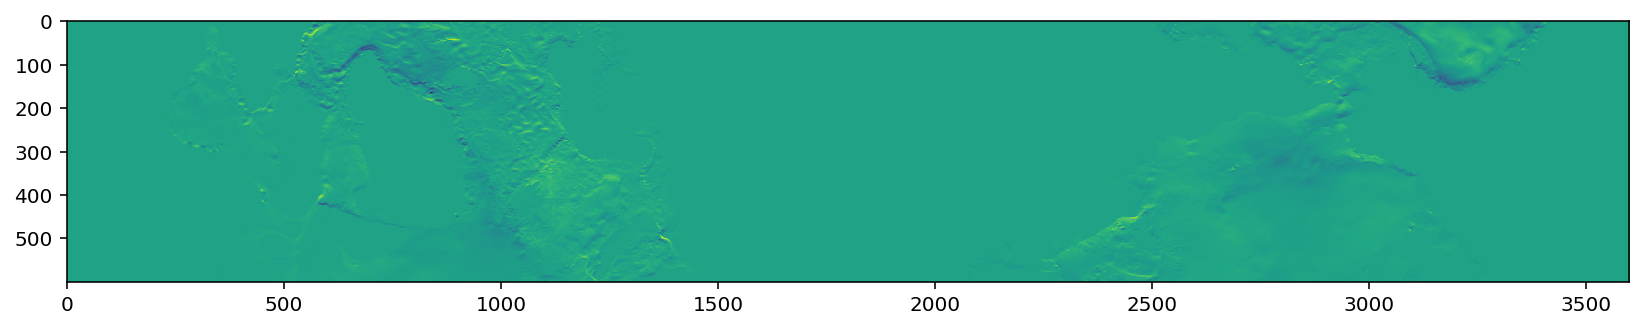

In [62]:
fig = plt.figure(figsize=(14,6))
ax = plt.axes()
ax.imshow(U_field_rcp1[0,0,:,:])

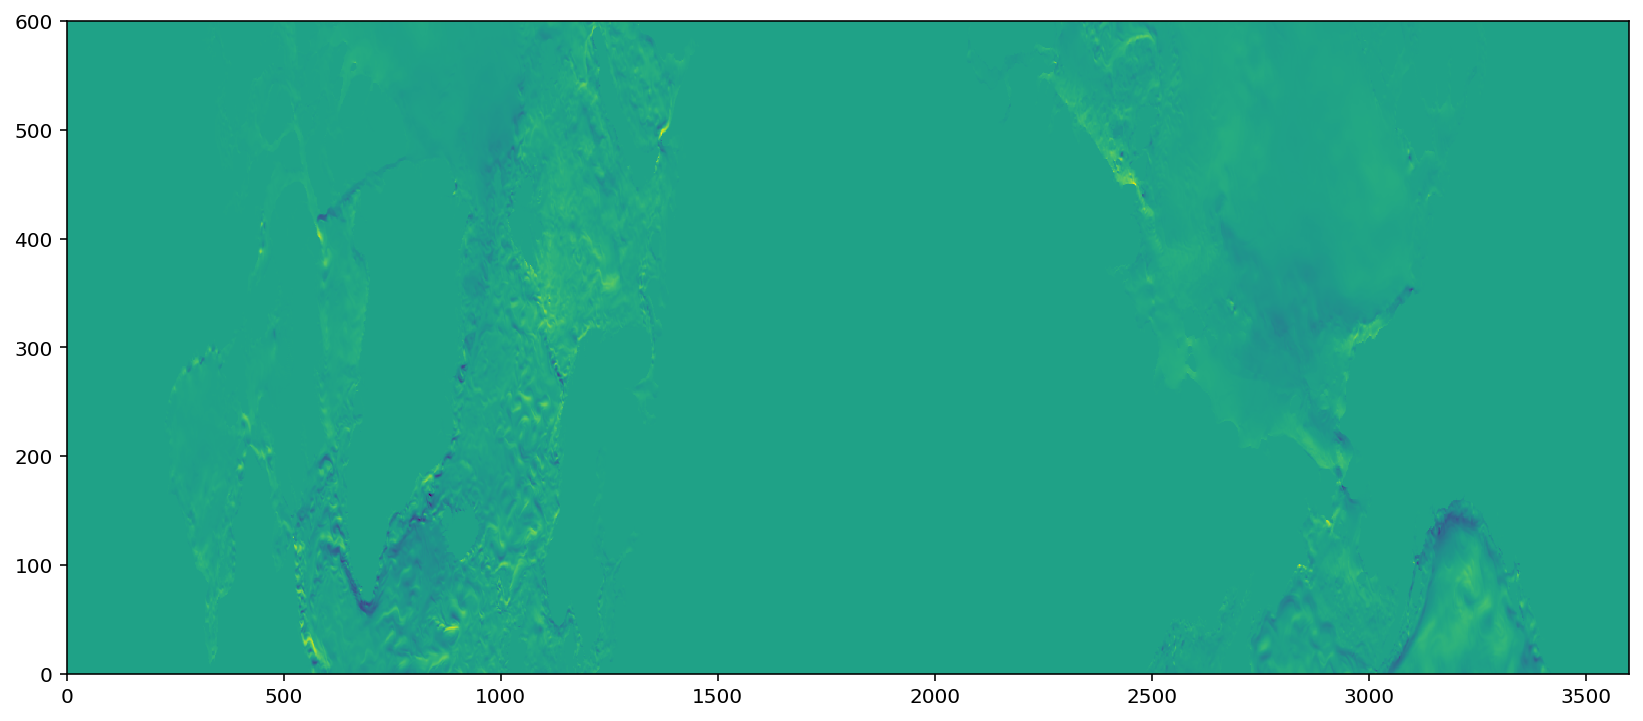

In [61]:
fig = plt.figure(figsize=(14,6))
ax = plt.axes()
ax.pcolormesh(U_field_rcp1[0,0,:,:])

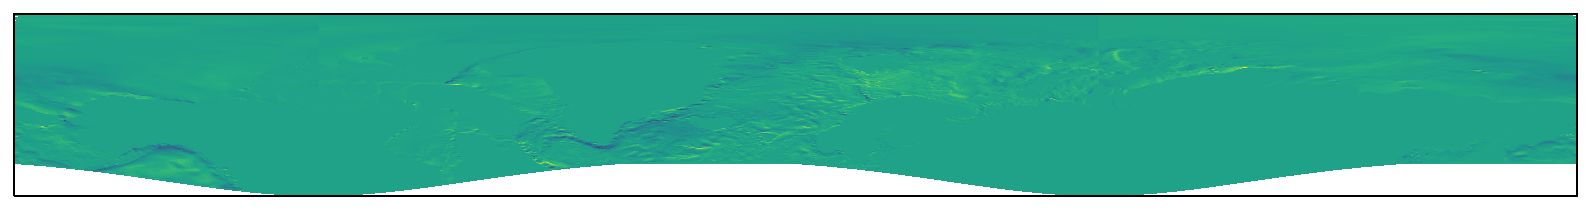

In [60]:
fig = plt.figure(figsize=(14,6))
ax = plt.axes(projection = ccrs.PlateCarree())
ax.pcolormesh(ULON, ULAT, U_field_rcp1[0,0,:,:], transform=ccrs.PlateCarree())

# CMEMS

In [63]:
cmems_ds = xr.open_dataset('/data/oceanparcels/input_data/CMEMS/CMEMS-GLORYS12V1-Arctic/GLOBAL_REANALYSIS_PHY_001_030-TDS_20161231_uv_uvice_con_thick.nc')

In [69]:
cmems_ds.vo.shape

(1, 1, 481, 4320)

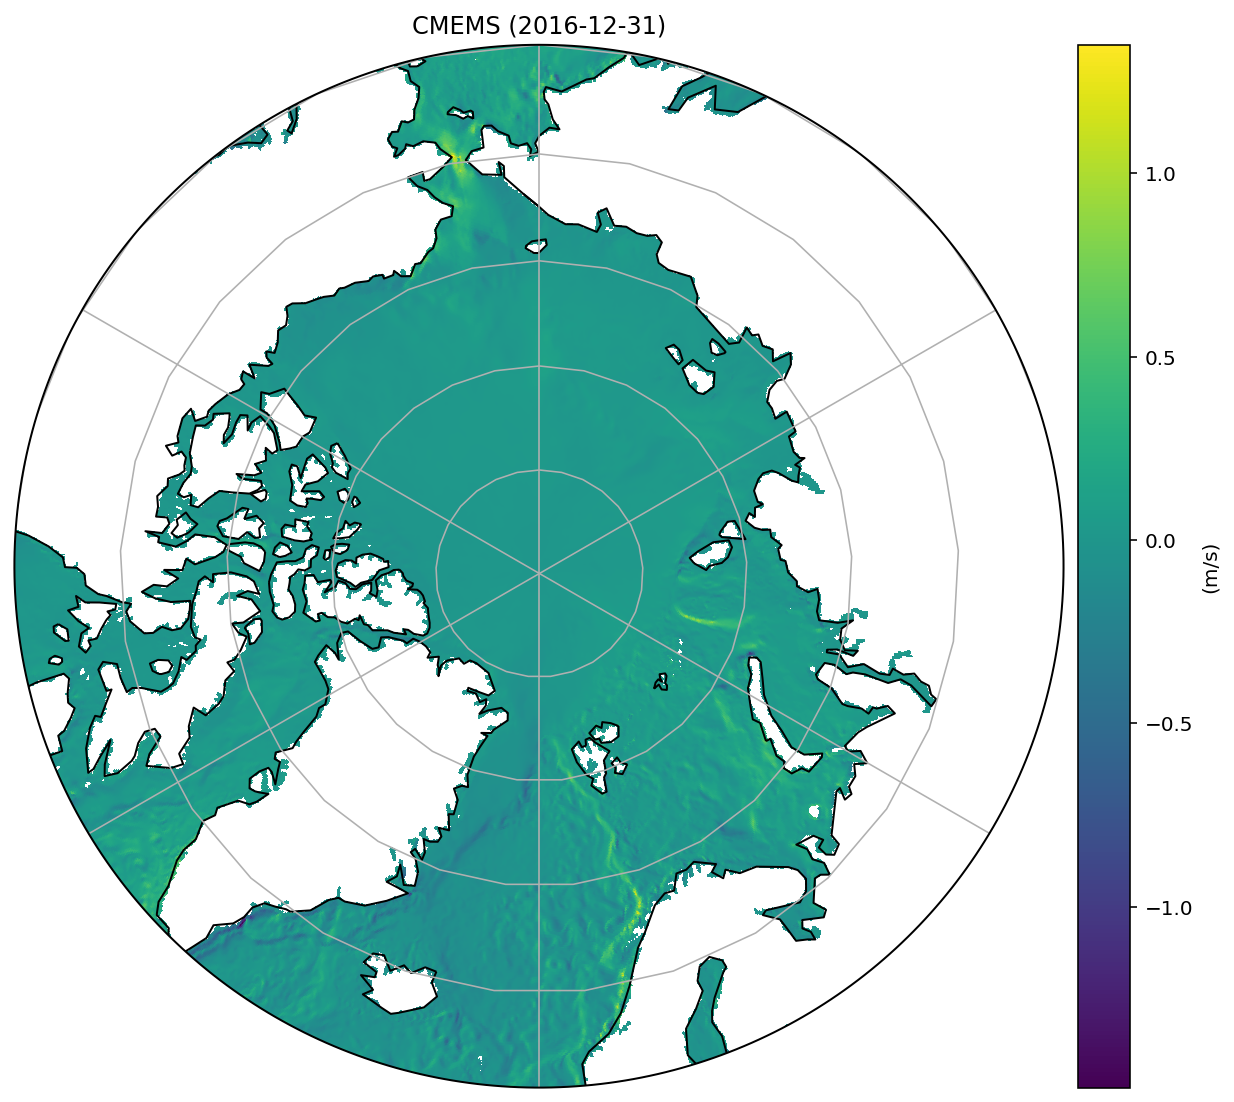

In [83]:
fig, ax = plot.field_from_dataset(cmems_ds.longitude, cmems_ds.latitude, cmems_ds.vo[0,0,:,:] , polar=True, size=(10,10), latRange=(60,90), title='CMEMS (2016-12-31)', units='m/s', export='CMEMS.png')

# Load fieldsets

In [20]:
timestamps = [[np.datetime64('2000-01-09', 'D') + np.timedelta64(day, 'D') for day in range(4007)]]
fieldset = fieldsetter.read_velocity_field(readdir_ocean_rcp + fieldfile_ocean_rcp1, 
                                           meshfile = readdir_mesh + meshfile,
                                           tindex = 'record',
                                           timestamps = timestamps)

In [106]:
fieldset.U.__dict__

{'name': 'U',
 'filebuffername': 'UVEL_5m',
 'data': dask.array<reshape, shape=(3, 600, 3600), dtype=float32, chunksize=(1, 600, 3600)>,
 'grid': <parcels.grid.CurvilinearZGrid at 0x7fe916871e10>,
 'igrid': 0,
 'lon': array([[-109.91097 , -109.821945, -109.73292 , ..., -110.17805 ,
         -110.08902 , -110.      ],
        [-109.91104 , -109.82209 , -109.73313 , ..., -110.17791 ,
         -110.08895 , -110.      ],
        [-109.91111 , -109.82223 , -109.733345, ..., -110.177765,
         -110.08888 , -110.      ],
        ...,
        [-109.99959 , -109.99918 , -109.99878 , ..., -110.00081 ,
         -110.00041 , -110.00001 ],
        [-109.99979 , -109.99959 , -109.99938 , ..., -110.00041 ,
         -110.000206, -110.00001 ],
        [-110.      , -110.      , -110.      , ..., -110.      ,
         -110.      , -110.      ]], dtype=float32),
 'lat': array([[48.14395 , 48.14404 , 48.144188, ..., 48.14404 , 48.14395 ,
         48.143925],
        [48.192413, 48.1925  , 48.192646, ..

In [23]:
fieldset.U.grid.timeslices.shape

(4007,)

In [15]:
fieldset.computeTimeChunk(fieldset.U.grid.time[0], 40)

172800.0

In [ ]:
fieldset.U.__dict__

In [64]:
fieldset.U.data.shape

(3, 600, 3600)

Plot first data index

(<Figure size 432x288 with 2 Axes>,
 <cartopy.mpl.geoaxes.GeoAxesSubplot at 0x7f982d6cd080>)

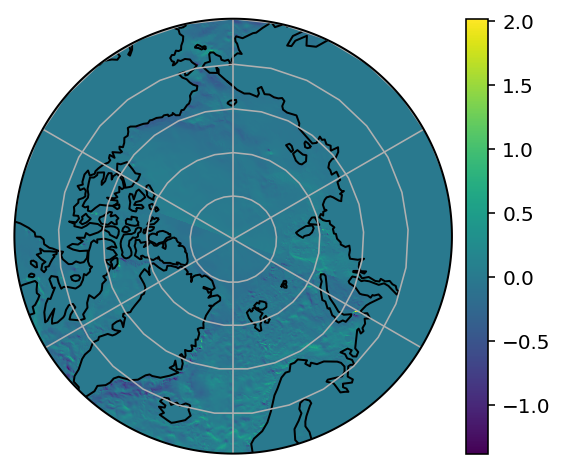

In [67]:
fig, ax = plot.field_from_dataset(fieldset.U.grid.lon, fieldset.U.grid.lat, fieldset.U.data[0], polar=True, latRange=(60,90))

Plot third data index

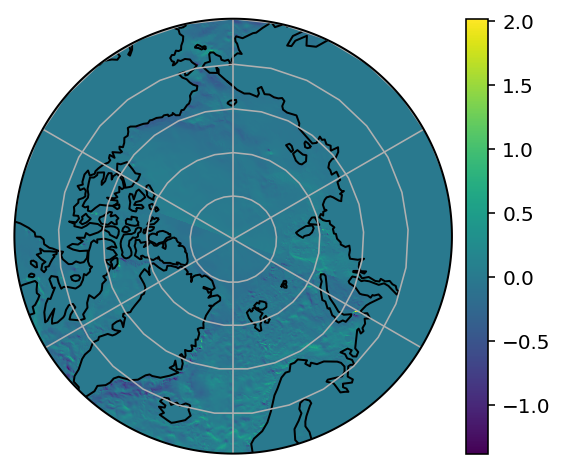

In [68]:
fig, ax = plot.field_from_dataset(fieldset.U.grid.lon, fieldset.U.grid.lat, fieldset.U.data[2], polar=True, latRange=(60,90))

Plot difference between the two

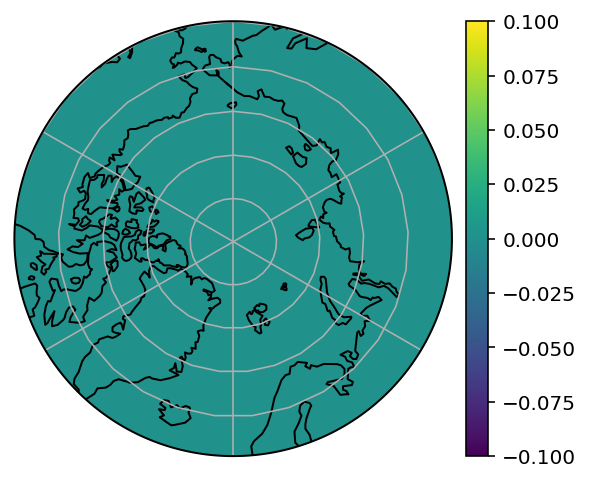

In [69]:
fig, ax = plot.field_from_dataset(fieldset.U.grid.lon, fieldset.U.grid.lat, fieldset.U.data[0]-fieldset.U.data[2], polar=True, latRange=(60,90))

No velocity difference is loaded between timestep one and two, while it does exist in the dataset:

(<Figure size 432x288 with 2 Axes>,
 <cartopy.mpl.geoaxes.GeoAxesSubplot at 0x7f98141408d0>)

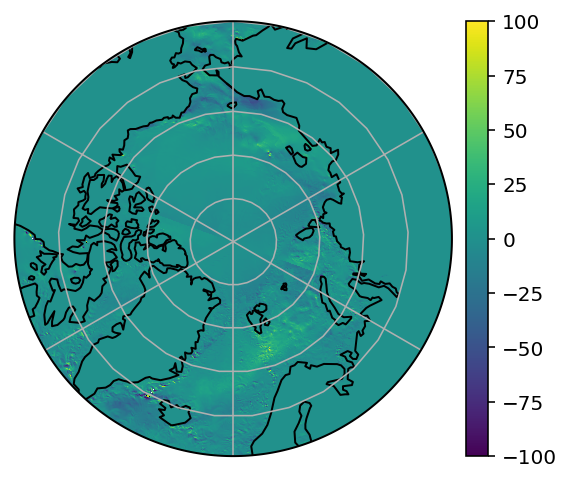

In [71]:
fig, ax = plot.field_from_dataset(ULON, ULAT, U_field_rcp1[0,0,:,:]-U_field_rcp1[2,0,:,:], latRange=(60,90), polar=True, vmin=-100, vmax=100)

Something is going wrong with selecting the time index when loading files into parcels.

In [104]:
ds_field_rcp2.UVEL_5m

<xarray.DataArray 'UVEL_5m' (record: 3650, time: 1, y: 600, x: 3600)>
[7884000000 values with dtype=float32]
Coordinates:
  * time     (time) float64 2.011e+07
Dimensions without coordinates: record, y, x
Attributes:
    long_name:  Zonal Velocity at 5 meters
    units:      cm/s
    grid_loc:   3221

In [99]:
ds_field_control_new.time

<xarray.DataArray 'time' (time: 365)>
array(['2000-01-01T00:00:00.000000000', '2000-01-02T00:00:00.000000000',
       '2000-01-03T00:00:00.000000000', ..., '2000-12-28T00:00:00.000000000',
       '2000-12-29T00:00:00.000000000', '2000-12-30T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2000-12-30
Attributes:
    standard_name:  time
    axis:           T

In [97]:
cmems_ds

<xarray.Dataset>
Dimensions:    (depth: 1, latitude: 481, longitude: 4320, time: 1)
Coordinates:
  * depth      (depth) float32 0.494025
  * latitude   (latitude) float32 50.0 50.083332 50.166668 ... 89.916664 90.0
  * time       (time) datetime64[ns] 2016-12-31T12:00:00
  * longitude  (longitude) float32 -180.0 -179.91667 ... 179.83333 179.91667
Data variables:
    siconc     (time, latitude, longitude) float32 ...
    vo         (time, depth, latitude, longitude) float32 ...
    uo         (time, depth, latitude, longitude) float32 ...
    usi        (time, latitude, longitude) float32 ...
    sithick    (time, latitude, longitude) float32 ...
    vsi        (time, latitude, longitude) float32 ...
Attributes:
    title:                              daily mean fields from Global Ocean P...
    easting:                            longitude
    northing:                           latitude
    history:                            2018/06/30 07:17:54 MERCATOR OCEAN Ne...
    source:       